## Gather Data

In [2]:
import requests, io
import pandas as pd
import zipfile
import gurobipy as gp
from gurobipy import GRB
from IPython.display import clear_output
import math


In [3]:


ridership_df = pd.DataFrame()

links = [
    'https://www.bart.gov/sites/default/files/2025-11/Ridership_202510.xlsx',
    'https://www.bart.gov/sites/default/files/2025-10/Ridership_202509.xlsx',
    'https://www.bart.gov/sites/default/files/2025-10/Ridership_202508.xlsx',
    'https://www.bart.gov/sites/default/files/2025-08/Ridership_202507.xlsx',
    'https://www.bart.gov/sites/default/files/2025-07/Ridership_202506.xlsx',
    'https://www.bart.gov/sites/default/files/2025-06/Ridership_202505.xlsx',
    'https://www.bart.gov/sites/default/files/2025-05/Ridership_202504.xlsx',
    'https://www.bart.gov/sites/default/files/2025-05/Ridership_202503.xlsx',
    'https://www.bart.gov/sites/default/files/2025-03/Ridership_202502.xlsx',
    'https://www.bart.gov/sites/default/files/2025-02/Ridership_202501.xlsx'
]

def extract_date_from_link(link):
    """
    Extract substring between 'Ridership_' and '.xlsx'.
    Example: 'Ridership_202510.xlsx' → '202510'
    """
    start = link.find("Ridership_") + len("Ridership_")
    end = link.find(".xlsx")
    return link[start:end]

def set_header_row(df, keyword="Exit Station Two-Letter Code"):
    """
    Find the row containing keyword and use it as the column headers.
    Return the cleaned DataFrame.
    """
    # locate the header row index
    header_idx = df.index[df.apply(lambda row: row.astype(str).str.contains(keyword).any(), axis=1)]
    
    if len(header_idx) == 0:
        # no header row found — return unchanged
        return df
    
    header_idx = header_idx[0]

    # set the header
    new_header = df.iloc[header_idx]
    df = df[header_idx + 1 :]  # drop the header row and all above it
    df.columns = new_header

    return df.reset_index(drop=True)


for link in links:
    response = requests.get(link)

    df = pd.read_excel(
        io.BytesIO(response.content),
        engine='openpyxl',
        header=None,                    
        sheet_name='Average Weekday'
    )

    df = set_header_row(df)

    # Add extracted date
    df["date"] = extract_date_from_link(link)            

    ridership_df = pd.concat([ridership_df, df], ignore_index=True)


In [4]:
# https://www.bart.gov/sites/default/files/docs/station-names.xls

station_map_df = pd.DataFrame({
    "code": [
        "RM","EN","EP","NB","BK","AS","MA","19","12","LM","FV","CL","SL","BF","HY","SH",
        "UC","FM","CN","PH","WC","LF","OR","RR","OW","EM","MT","PL","CC","16","24","GP",
        "BP","DC","CM","CV","ED","NC","WP","SS","SB","SO","MB","WD","OA","WS","AN","PC",
        "ML","BE"
    ],
    "stop_name": [
        "Richmond","El Cerrito Del Norte","El Cerrito Plaza","North Berkeley",
        "Downtown Berkeley","Ashby","MacArthur","19th Street Oakland",
        "12th Street / Oakland City Center","Lake Merritt","Fruitvale","Coliseum - OAC",
        "San Leandro","Bay Fair","Hayward","South Hayward","Union City","Fremont",
        "Concord","Pleasant Hill / Contra Costa Centre","Walnut Creek","Lafayette","Orinda","Rockridge",
        "West Oakland","Embarcadero","Montgomery Street","Powell Street",
        "Civic Center / UN Plaza","16th Street / Mission","24th Street / Mission","Glen Park",
        "Balboa Park","Daly City","Colma","Castro Valley","Dublin / Pleasanton",
        "North Concord / Martinez","Pittsburg / Bay Point","South San Francisco","San Bruno",
        "San Francisco International Airport","Millbrae (Caltrain Transfer Platform)","West Dublin / Pleasanton",
        "Oakland International Airport Station","Warm Springs / South Fremont","Antioch","Pittsburg Center",
        "Milpitas","Berryessa / North San Jose"
    ]
})

In [5]:
GTFS_URL = "https://www.bart.gov/dev/schedules/google_transit.zip"

response = requests.get(GTFS_URL)
z = zipfile.ZipFile(io.BytesIO(response.content))

# Load GTFS components into DataFrames
routes = pd.read_csv(z.open("routes.txt"))
stops = pd.read_csv(z.open("stops.txt"))
trips = pd.read_csv(z.open("trips.txt"), dtype={"route_id": str})
stop_times = pd.read_csv(z.open("stop_times.txt"))
calendar = pd.read_csv(z.open("calendar.txt"))

# Join trips with routes
trip_routes = trips.merge(routes, on="route_id", how="left")

# Join stop_times with stops
times_with_stops = stop_times.merge(stops, on="stop_id", how="left")

# Final joined table
full_schedule = (
    trip_routes
    .merge(times_with_stops, on="trip_id", how="left")
    .sort_values(["route_id", "trip_id", "stop_sequence"])
)

full_schedule['stop_name'] = full_schedule['stop_name'].str.replace("", "", regex=False)

mapped_schedule = full_schedule.merge(station_map_df, left_on="stop_name", right_on="stop_name", how="left")

# mapped_schedule.to_excel("C:/Users/chhri/Downloads/bart_full_schedule.xlsx")

In [ ]:
df = ridership_df.rename(columns={'Exit Station Two-Letter Code': 'from_stop'})

# 2. Melt all OD columns into long form
df_long = df.melt(
    id_vars=['date', 'from_stop'],     # keep these as identifiers
    var_name='to_stop',                # new column representing destination
    value_name='ridership'             # ridership value
)

# 3. Drop rows where to_stop is NaN (your last row has a NaN column)
df_long = df_long.dropna(subset=['to_stop'])

# Optional: sort nicely
df_long = df_long.sort_values(['date', 'from_stop', 'to_stop']).reset_index(drop=True)

df_avg = (
    df_long
    .groupby(['from_stop', 'to_stop'], as_index=False)['ridership']
    .mean()
    .rename(columns={'ridership': 'avg_ridership'})
)

# Round up avg ridership to nearest integer and handle missing values
df_avg['avg_ridership'] = df_avg['avg_ridership'].apply(lambda x: int(math.ceil(x)) if pd.notna(x) else 0)

In [94]:
stops_df = mapped_schedule.copy()

def parse_gtfs_time(t):
    """
    Parse time strings like '06:11:00' or '24:05:00' into minutes since midnight.
    GTFS allows hours >= 24, meaning times past midnight but same service day.
    """
    if pd.isna(t):
        return np.nan
    hh, mm, ss = map(int, str(t).split(":"))
    return hh * 60 + mm + ss / 60.0   # minutes since midnight (possibly > 24*60)

def compute_travel_times(stops_df):
    df = stops_df.copy()

    # parse times into numeric minutes
    df["arr_min"] = df["arrival_time"].apply(parse_gtfs_time)
    df["dep_min"] = df["departure_time"].apply(parse_gtfs_time)

    # sort properly
    df = df.sort_values(["route_id", "trip_id", "stop_sequence"])

    arc_rows = []

    for (route_id, trip_id), group in df.groupby(["route_id", "trip_id"]):
        group = group.sort_values("stop_sequence")

        dep_times = group["dep_min"].values
        arr_times = group["arr_min"].values
        seq      = group["stop_sequence"].values
        codes    = group["code"].values
        dep_str  = group["departure_time"].values
        arr_str  = group["arrival_time"].values

        for i in range(len(group) - 1):
            travel = arr_times[i+1] - dep_times[i]   # minutes
            travel_min = int(round(travel))

            arc_rows.append({
                "route_id": route_id,
                "trip_id": trip_id,
                "from_stop": codes[i],
                "to_stop": codes[i+1],
                "from_seq": seq[i],
                "to_seq": seq[i+1],
                "dep_time_str": dep_str[i],
                "arr_time_str": arr_str[i+1],
                "travel_time_min": travel_min,
                "arr_time": arr_times[i+1],
                "dep_time": dep_times[i]
            })
    df = pd.DataFrame(arc_rows)

    arc_rows = df.merge(df_avg, how='left', on=['from_stop','to_stop'])

    return pd.DataFrame(arc_rows)

arc_df = compute_travel_times(stops_df)

arc_df['from_stop_to_stop'] = arc_df['from_stop'] + "_" + arc_df['to_stop']

arc_df = arc_df[~arc_df.astype(str).apply(lambda row: row.str.contains('nan')).any(axis=1)]

arc_df[(arc_df['trip_id'] == 1859829) | (arc_df['trip_id'] == 1859830)]

# this is to normalize the avg weekdaily ridership figure to a riders/train per hour number.
arc_df['tph'] = arc_df.groupby('from_stop')['dep_time'].transform('count') * (60 / (arc_df['dep_time'].max() - arc_df['dep_time'].min()))
arc_df['normalized_demand'] = arc_df['avg_ridership'] / arc_df['tph']

In [83]:

def build_time_expanded_graph(
    arc_df,
    stop_from_col="from_stop",
    stop_to_col="to_stop",
    dep_time_col="dep_time",
    arr_time_col="arr_time",
):
    """
    Build a time-expanded graph G = (V, A) from a timetable dataframe.
    
    Returns:
        V         : sorted list of nodes (station, time)
        A         : dict {arc_id: {"kind", "from_node", "to_node", "demand"}}
        incoming  : dict {node: [arc_id, ...]}
        outgoing  : dict {node: [arc_id, ...]}
    """

    # --- 1. Copy & ensure types ---
    df = arc_df.copy()

    # Make sure times are numeric (floats/ints)
    df[dep_time_col] = df[dep_time_col].astype(float)
    df[arr_time_col] = df[arr_time_col].astype(float)

    # Station labels as strings (just in case)
    df[stop_from_col] = df[stop_from_col].astype(str)
    df[stop_to_col]   = df[stop_to_col].astype(str)

    # --- 2. Build stage nodes (station, time) ---
    df["from_node"] = list(zip(df[stop_from_col], df[dep_time_col]))
    df["to_node"]   = list(zip(df[stop_to_col],   df[arr_time_col]))

    V = sorted(set(df["from_node"].tolist()) | set(df["to_node"].tolist()))

    # --- 3. Initialize arc dict ---
    A = {}
    arc_id_counter = 0

    def new_arc_id(prefix):
        nonlocal arc_id_counter
        arc_id = f"{prefix}_{arc_id_counter}"
        arc_id_counter += 1
        return arc_id

    # --- 4. Stage arcs (from the rows themselves) ---
    for idx, row in df.iterrows():
        arc_id = new_arc_id("stage")
        A[arc_id] = {
            "kind":      "stage",
            "from_node": row["from_node"],
            "to_node":   row["to_node"],
            # your demand column name:
            "demand":    float(row.get("normalized_demand", 0.0)),
            "row_idx":   int(idx),  # optional: link back to original row
        }

    # --- 5. Build per-station time sets ---
    times_by_station = {}
    for (station, t) in V:
        times_by_station.setdefault(station, set()).add(t)

    # --- 6. Wait arcs (within each station between consecutive times) ---
    for st, times in times_by_station.items():
        sorted_times = sorted(times)

        # If more than one event at this station, connect consecutive events
        if len(sorted_times) >= 2:
            for t1, t2 in zip(sorted_times[:-1], sorted_times[1:]):
                from_node = (st, t1)
                to_node   = (st, t2)
                arc_id = new_arc_id("wait")
                A[arc_id] = {
                    "kind":      "wait",
                    "from_node": from_node,
                    "to_node":   to_node,
                    "demand":    0.0,
                }
        else:
            # Only one time at this station.
            # Add a self-loop wait arc so the node has in & out degree ≥ 1,
            # even if there are no stage arcs here.
            t = sorted_times[0]
            from_node = (st, t)
            to_node   = (st, t)
            arc_id = new_arc_id("wait_single")
            A[arc_id] = {
                "kind":      "wait",
                "from_node": from_node,
                "to_node":   to_node,
                "demand":    0.0,
            }

    # --- 7. Overnight arcs (wrap last time → first time at each station) ---
    # This enforces "circulation over the day" per station.
    for st, times in times_by_station.items():
        sorted_times = sorted(times)
        first_t = sorted_times[0]
        last_t  = sorted_times[-1]
        from_node = (st, last_t)
        to_node   = (st, first_t)

        arc_id = new_arc_id("overnight")
        A[arc_id] = {
            "kind":      "overnight",
            "from_node": from_node,
            "to_node":   to_node,
            "demand":    0.0,
        }

    # --- 8. Build adjacency lists for flow conservation ---
    incoming = {v: [] for v in V}
    outgoing = {v: [] for v in V}

    for arc_id, a_data in A.items():
        u = a_data["from_node"]
        v = a_data["to_node"]
        # Ensure all nodes are present
        if u not in outgoing:
            outgoing[u] = []
            if u not in incoming:
                incoming[u] = []
            V.append(u)
        if v not in incoming:
            incoming[v] = []
            if v not in outgoing:
                outgoing[v] = []
            V.append(v)
        outgoing[u].append(arc_id)
        incoming[v].append(arc_id)

    # Sort V again in case we appended any new nodes
    V = sorted(set(V))

    # --- 9. Optional: quick sanity checks ---
    # Nodes with no in or out arcs (should be none)
    bad_nodes = [
        v for v in V
        if len(incoming[v]) == 0 or len(outgoing[v]) == 0
    ]
    if bad_nodes:
        print("WARNING: some nodes have zero in-degree or out-degree:")
        for v in bad_nodes:
            print(
                f"  node={v} in_deg={len(incoming[v])} "
                f"out_deg={len(outgoing[v])}"
            )

    return V, A, incoming, outgoing
# Build graph from your timetable
V, A, incoming, outgoing = build_time_expanded_graph(arc_df)

seats_per_unit = 54
max_units_per_train = 10

model = gp.Model("Bart_Fleet_Optimization")

# One integer var f[a] per arc
f = model.addVars(A.keys(), vtype=GRB.INTEGER, lb=0, name="f")

# Flow conservation at all nodes
for v in V:
    model.addConstr(
        gp.quicksum(f[a] for a in incoming[v]) ==
        gp.quicksum(f[a] for a in outgoing[v]),
        name=f"flow_{v}"
    )

# Demand + capacity on stage arcs
for arc_id, a_data in A.items():
    if a_data["kind"] == "stage":
        # capacity must cover demand
        model.addConstr(
            seats_per_unit * f[arc_id] >= a_data["demand"],
            name=f"demand_{arc_id}"
        )
        # optional max coupling constraint
        model.addConstr(
            f[arc_id] <= max_units_per_train,
            name=f"max_units_{arc_id}"
        )

# Objective: minimize number of units in overnight arcs
overnight_arcs = [arc_id for arc_id, a_data in A.items()
                  if a_data["kind"] == "overnight"]

model.setObjective(
    gp.quicksum(f[a] for a in overnight_arcs),
    GRB.MINIMIZE
)

model.optimize()


Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700K, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 117726 rows, 67838 columns and 235450 nonzeros
Model fingerprint: 0xdab28511
Variable types: 0 continuous, 67838 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 3e+01]
Presolve removed 106422 rows and 42725 columns
Presolve time: 0.06s
Presolved: 11304 rows, 25113 columns, 50226 nonzeros
Variable types: 0 continuous, 25113 integer (0 binary)
Performing another presolve...
Presolve removed 2462 rows and 5242 columns
Presolve time: 0.07s

Root relaxation: objective 2.510000e+02, 4665 iterations, 0.10 seconds (0.19 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl 

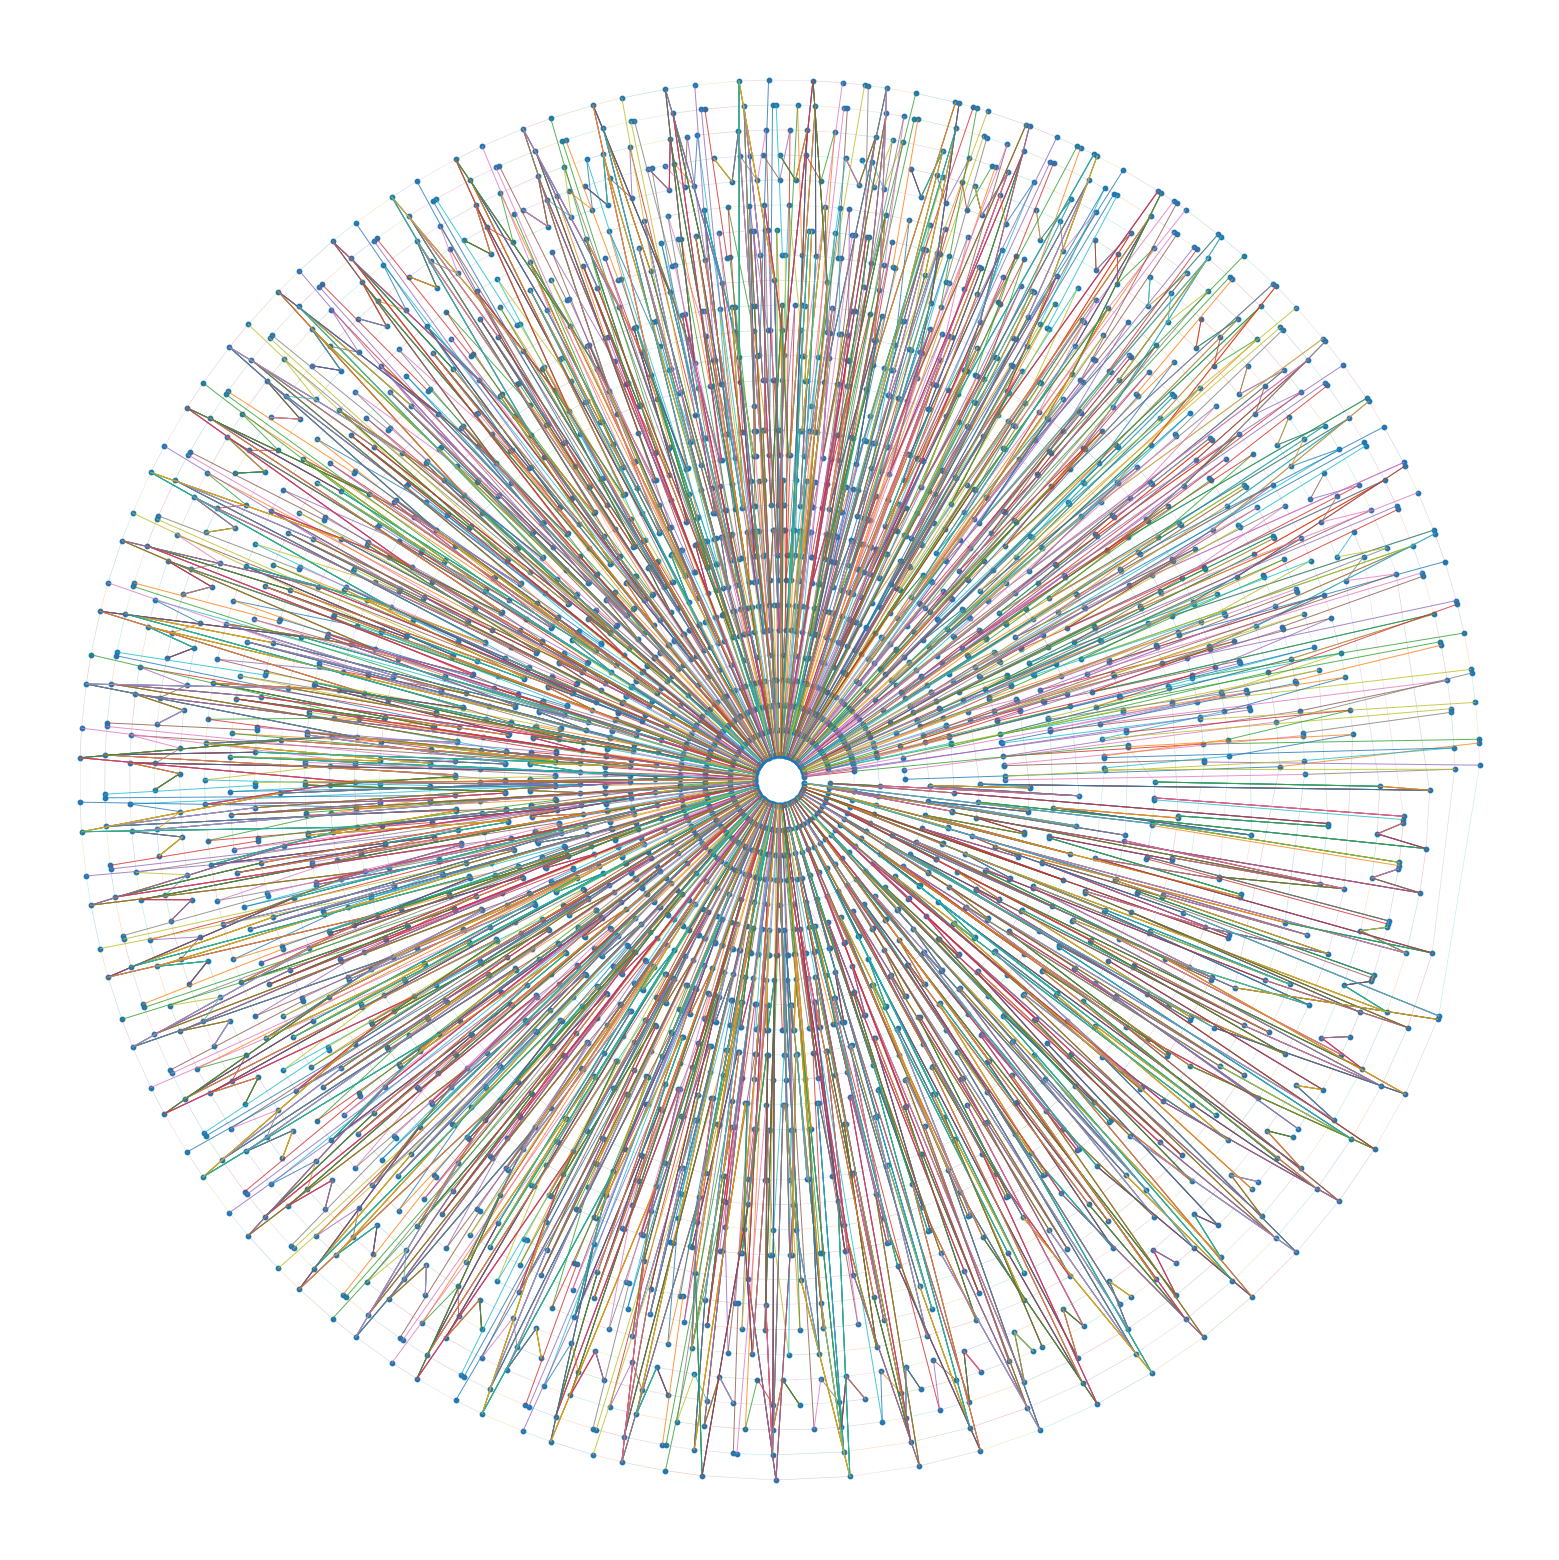

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Assumes arc_df already exists with from_stop, to_stop, dep_time, arr_time ---

df = arc_df[arc_df['route_id'] == '1'].copy()

# 1) Make sure times are numeric and collect unique event times
for col in ["dep_time", "arr_time"]:
    df[col] = df[col].astype(float)

all_times = np.unique(df[["dep_time", "arr_time"]].values)
all_times_sorted = np.sort(all_times)

# Map each time to an index 0..T-1
time_to_idx = {t: i for i, t in enumerate(all_times_sorted)}
T = len(all_times_sorted)

# 2) Station → radius mapping (concentric circles)
stations = sorted(set(df["from_stop"]) | set(df["to_stop"]))
station_to_radius = {st: 1.0 + i for i, st in enumerate(stations)}

# 3) Build node coordinates for every (station, time) that appears
nodes = {}  # key: (station, time_idx) → (x, y)

for _, row in df.iterrows():
    s_from = row["from_stop"]
    s_to   = row["to_stop"]
    t_dep_idx = time_to_idx[row["dep_time"]]
    t_arr_idx = time_to_idx[row["arr_time"]]

    for (s, t_idx) in [(s_from, t_dep_idx), (s_to, t_arr_idx)]:
        if (s, t_idx) not in nodes:
            r = station_to_radius[s]
            theta = 2 * np.pi * t_idx / T
            x = r * np.cos(theta)
            y = r * np.sin(theta)
            nodes[(s, t_idx)] = (x, y)

# 4) Build arcs: stage + wait + optional overnight
stage_arcs = []
wait_arcs  = []
overnight_arcs = []

# Stage arcs from dataframe
for _, row in df.iterrows():
    s_from = row["from_stop"]
    s_to   = row["to_stop"]
    t_dep_idx = time_to_idx[row["dep_time"]]
    t_arr_idx = time_to_idx[row["arr_time"]]
    stage_arcs.append(((s_from, t_dep_idx), (s_to, t_arr_idx)))

# Wait + overnight arcs per station
times_by_station = {}
for (s, t_idx) in nodes.keys():
    times_by_station.setdefault(s, []).append(t_idx)

for s, t_list in times_by_station.items():
    t_list = sorted(t_list)
    # wait arcs
    for t1, t2 in zip(t_list[:-1], t_list[1:]):
        wait_arcs.append(((s, t1), (s, t2)))
    # overnight (wrap)
    if len(t_list) > 1:
        wait_arcs.append(((s, t_list[-1]), (s, t_list[0])))

# 5) Plot
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_aspect("equal")
ax.axis("off")

# draw nodes
xs, ys = zip(*nodes.values())
ax.scatter(xs, ys, s=10, label='Antioch to SF Intl Airport SFO/Millbrae')

# helper to draw arc list
def draw_arcs(arcs, lw=0.5, alpha=0.7):
    for u, v in arcs:
        x1, y1 = nodes[u]
        x2, y2 = nodes[v]
        ax.plot([x1, x2], [y1, y2], linewidth=lw, alpha=alpha)

# draw stage arcs a bit thicker
draw_arcs(wait_arcs, lw=0.4, alpha=0.3)
draw_arcs(stage_arcs, lw=0.7, alpha=0.8)

# (optional) label stations on each ring
# for s, r in station_to_radius.items():
#     ax.text(r, 0, s, ha="left", va="center", fontsize=4)

plt.show()


In [107]:
arc_df.dtypes

route_id              object
trip_id                int64
from_stop             object
to_stop               object
from_seq               int64
to_seq                 int64
dep_time_str          object
arr_time_str          object
travel_time_min        int64
arr_time             float64
dep_time             float64
avg_ridership        float64
from_stop_to_stop     object
tph                  float64
normalized_demand    float64
dtype: object